### Baysor testing

It seems to be not feasible to run Baysor on a full coronal mouse section. We need a strategy for subdividing these data and re-stitching after segmentation.

Questions to answer in this notebook: 

- How much data can be reasonably processed by Baysor?
- What is the relationship between data size and runtime?
- What is the relationship between data size and memory usage?
- How can we stitch tiles back together?
- What is the optimal tile size given compute resources available? 

In [1]:
import numpy as np
import seaborn
import matplotlib.pyplot as plt

In [2]:
# modify path so we can import a custom module
import sys
sys.path.append('.')

from segmentation import SpotTable

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
data_path = '../../../data/merfish_test/202203031129_60988224_VMSC01001/'
raw_data_file = data_path + 'detected_transcripts.csv'
np_file = data_path + 'detected_transcripts.npz'
baysor_bin = '../../../Baysor/bin/Baysor'

In [5]:
if not os.path.exists(np_file):
    print("Loading csv..")
    dtype = [('x', 'float32'), ('y', 'float32'), ('z', 'float32'), ('gene', 'int')]
    data = np.loadtxt(raw_data_file, skiprows=1, usecols=[2,3,4,9], delimiter=',', dtype=dtype)
    print("Recompressing to npz..")
    np.savez_compressed(np_file, data)
else:
    print("Loading from npz..")
    data = np.load(np_file)['arr_0']

Loading from npz..


## Test Baysor performance on datasets of different sizes

In [6]:
spot_table = SpotTable(data)

In [7]:
# make sub-regions of increasing size
regions = [
    (200,  (2700, 2900), (4450, 4650)),
    (400,  (2600, 3000), (4400, 4800)),
    (800,  (2200, 3000), (4000, 4800)),
    (1600, (1400, 3000), (3200, 4800)),
    (3200, (1000, 4200), (2000, 5200)),
]

region_tables = {}
for size, xlim, ylim in regions:
    region_tables[size] = spot_table.get_subregion(xlim, ylim)

**After generating csv files above, run baysor on each like:**

```
for i in transcripts_*.csv; do echo $i; time Baysor run $i -o "$i"_results -s 5; done
```

Tile size 200 (120244 spots) took 0.05 hours
Tile size 400 (485073 spots) took 0.21 hours
Tile size 800 (1537795 spots) took 0.66 hours
Tile size 1600 (4756266 spots) took 2.19 hours
Tile size 3200 (18806503 spots) took 1.30 hours


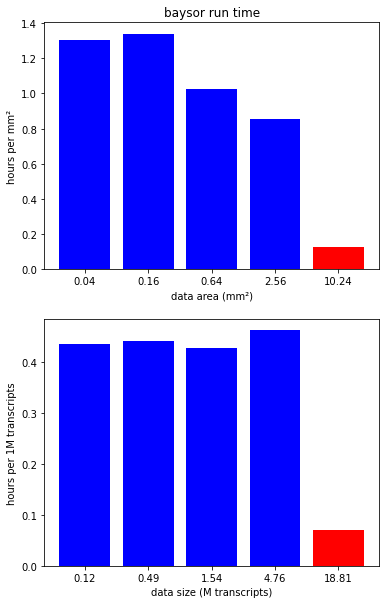

In [8]:
# extract timing from log files
import re, datetime
def get_time_from_log_line(line):
    m = re.match(r'\[(\d+):(\d+):(\d+)\] .*', line)
    h, m, s = m.groups()
    t = datetime.time(int(h), int(m), int(s))
    d = datetime.date.today()
    return datetime.datetime.combine(d, t)
    
areas = []
durations = []
colors = []
for size, xlim, ylim in regions:
    log_file = data_path + f'transcripts_{size:04d}um_log.log'
    log = open(log_file, 'r').readlines()
    start = get_time_from_log_line(log[0])
    stop = get_time_from_log_line(log[-1])
    dif = (stop - start).total_seconds()
    print(f"Tile size {size} ({len(region_tables[size])} spots) took {dif/3600:0.2f} hours") 
    area = (size * 1e-3) ** 2
    areas.append(area)
    durations.append(dif)
    finished = 'All done!' in log[-1]
    colors.append('b' if finished else 'r')

fig, ax = plt.subplots(2, figsize=(6, 10))

ax[0].bar(range(len(durations)), np.array(durations) / np.array(areas) / 3600, color=colors)
ax[0].set_ylabel('hours per mm²')
ax[0].set_title('baysor run time')
ax[0].set_xlabel('data area (mm²)')
ax[0].set_xticks(list(range(len(durations))))
ax[0].set_xticklabels([f'{a:.2f}' for a in areas]);

lengths = np.array([len(rgn) for rgn in region_tables.values()])
ax[1].bar(range(len(durations)), (np.array(durations) / 3600) * (1e6 / lengths), color=colors)
ax[1].set_ylabel('hours per 1M transcripts')
ax[1].set_xlabel('data size (M transcripts)')
ax[1].set_xticks(list(range(len(durations))))
ax[1].set_xticklabels([f'{a/1e6:.2f}' for a in lengths]);


## Memory usage

Manually watching memory usage, I see:

```
   200 μm : 1 GB
   400 μm : 3-4.5 GB
   800 μm : 9-12 GB
  1600 μm : 25-27 GB
  3200 μm : (out of memory)
```

There may be periods when memory usage spikes much higher than the values listed here

## Inspect some results

In [9]:
result_file = data_path + f'transcripts_1600um.csv_results'
result_table = SpotTable.load_baysor(result_file)

In [10]:
def cell_palette(cells):
    cell_set = np.unique(cells)
    n_cells = len(cell_set)
    colors = seaborn.color_palette('dark', 30)
    palette = {cid: colors[i%len(colors)] for i, cid in enumerate(cell_set)}
    palette[0] = (0, 1, 1)
    palette[-1] = (1, 1, 0)
    palette[-2] = (1, 0, 1)
    palette[-3] = (0, 1, 0)
    palette[-4] = (0, 0, 1)
    palette[-5] = (1, 0, 0)
    return palette

def cell_scatter_plot(spot_table, ax, alpha=0.2, size=1.5, z_slice=None):
    if z_slice is not None:
        zvals = np.unique(spot_table.data['z'])
        zval = zvals[int(z_slice * (len(zvals)-1))]
        mask = spot_table.data['z'] == zval
        spot_table = spot_table[mask]
    
    seaborn.scatterplot(
        x=spot_table.data['x'], 
        y=spot_table.data['y'], 
        hue=spot_table.cell_ids, 
        palette=cell_palette(spot_table.cell_ids), 
        linewidth=0, 
        alpha=alpha,
        size=size,
        ax=ax,
        legend=False
    )
    ax.set_aspect('equal')

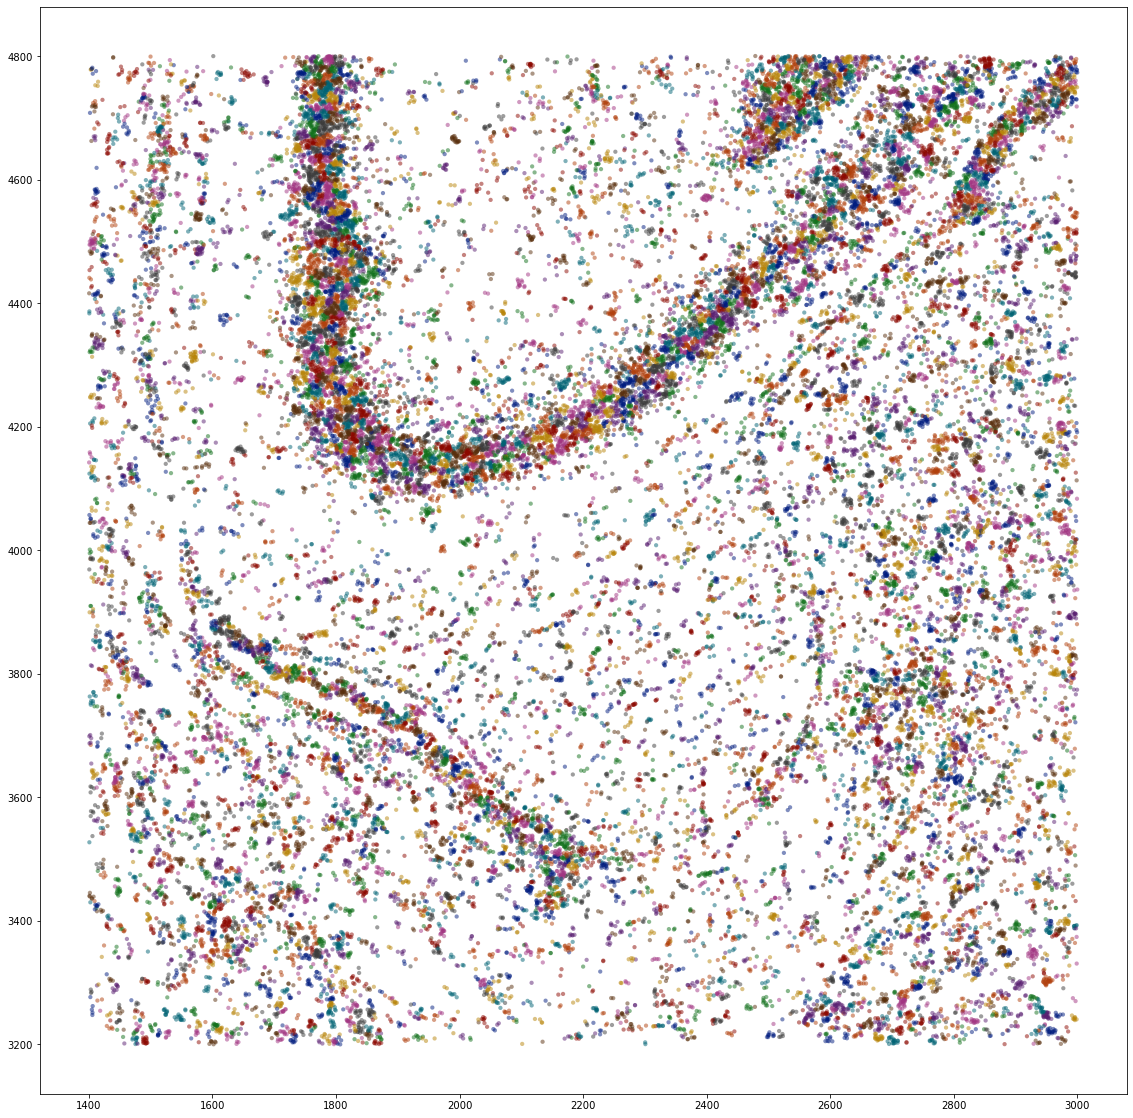

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))
cell_scatter_plot(result_table[::100], ax=ax, size=1, alpha=0.5)

<AxesSubplot:>

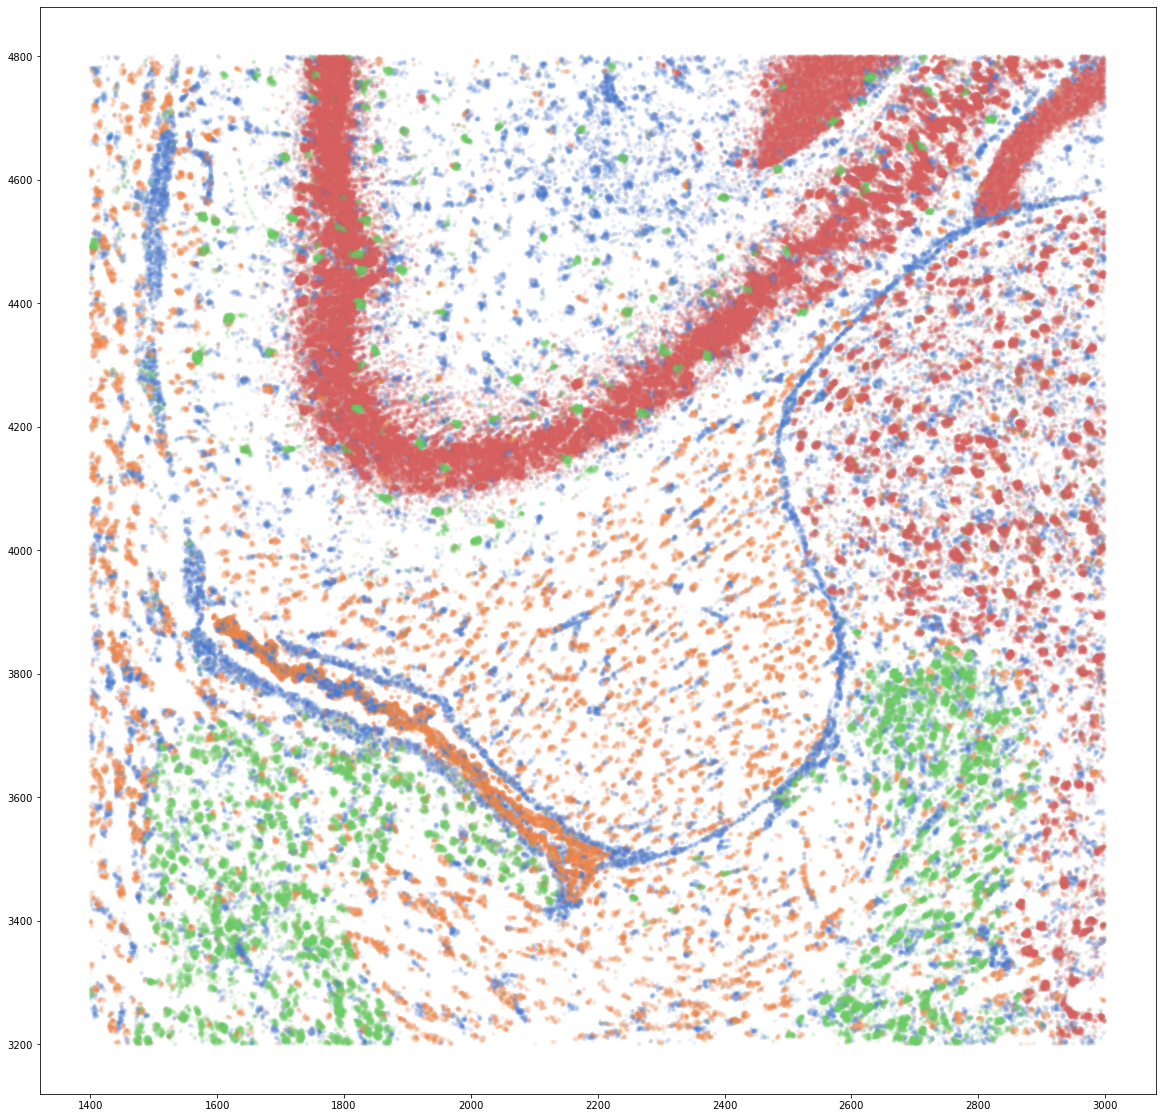

In [12]:
n_clusters = len(np.unique(result_table.data['cluster']))
palette = seaborn.color_palette('muted', n_clusters)

fig, ax = plt.subplots(figsize=(20, 20))
seaborn.scatterplot(
    x=result_table.data['x'][::10], 
    y=result_table.data['y'][::10], 
    hue=result_table.data['cluster'][::10], 
    palette=palette, 
    linewidth=0, 
    alpha=0.1, 
    size=1,
    ax=ax,
    legend=False
)


## Try stitching tiles together

Split the 1600 μm region above into 4x800 μm regions with a 15 μm padding around each tile (30 μm overlap)

In [134]:
# split large spot table into tiles
padding = 15
subdivide = 2
full_size, full_xlim, full_ylim = regions[3]
full_table = region_tables[full_size]
tile_size = full_size / subdivide
tiles = {}

for i in range(subdivide):
    for j in range(subdivide):
        xlim = full_xlim[0] + tile_size * i - padding, full_xlim[0] + tile_size * (i + 1) + padding
        ylim = full_ylim[0] + tile_size * j - padding, full_ylim[0] + tile_size * (j + 1) + padding

        tiles[i, j] = full_table.get_subregion(xlim=xlim, ylim=ylim)

In [135]:
# Load segmentation from baysor result files
for (i, j), tile in tiles.items():
    result_file = data_path + f'tile_{i}_{j}.csv_results'
    
    # load baysor result so we can QC spots 
    baysor_data = load_baysor_result(result_file, remove_noise=False, remove_no_cell=False)
    mask = (~baysor_data['is_noise']) & (baysor_data['cell'] > 0)
    parent_mask = tile.map_mask_to_parent(mask)
    
    # regenerate tile as subset of full table restricted to qc-passed spots
    tiles[i, j] = full_table[parent_mask]
    tiles[i, j].data = baysor_data[mask]
    tiles[i, j].cell_ids = tiles[i, j].data['cell']
                                       

In [136]:
# create an array of spot->cell assignments.
cells = np.empty(len(full_table), dtype=int)
cells.fill(-1)
full_table.cell_ids = cells

In [137]:
# remove partial cells from edges of first tile -- 
# include only cels that have no spots in a 5 μm padding region
def cell_mask_within_padding(tile, padding=5.0):
    tile_xlim, tile_ylim = tile.parent_region
    include_xlim = (tile_xlim[0] + padding, tile_xlim[1] - padding) 
    include_ylim = (tile_ylim[0] + padding, tile_ylim[1] - padding) 
    include_cells = tile.cells_inside_region(xlim=include_xlim, ylim=include_ylim)
    include_mask = tile.cell_mask(include_cells)
    parent_mask = tile.map_mask_to_parent(include_mask)
    return include_mask, parent_mask


tile1 = tiles[0, 0]
tile_mask1, parent_mask1 = cell_mask_within_padding(tile1)

# copy all retained cells from first tile to full table
cells[parent_mask1] = tile1.cell_ids[tile_mask1]

In [138]:
# remove partial cells from edge of second tile
tile2 = tiles[1, 0]
tile_mask2, parent_mask2 = cell_mask_within_padding(tile2)

# increment cell IDs in new tile
tile2.cell_ids[tile2.cell_ids > 0] += cells.max()
tile2.cell_ids_changed()

# Collect information about cells that will be only partially replaced
overlap = parent_mask1 & parent_mask2
overlapped_cell_ids = np.unique(cells[overlap])
overlapped_cells = []
for cid in overlapped_cell_ids:
    cind = tile1.cell_indices(cid)
    cpind = tile1.map_indices_to_parent(cind)
    overlap_rgn = overlap[cpind]
    overlap_count = overlap_rgn.sum()
    overlap_frac = overlap_count / len(cind)
    if 0.9 > overlap_frac > 0.1 and len(cind) > 100:
        overlapped_cells.append({
            'original_cell_id': cid,
            'original_cell_size': len(cind),
            'original_cell_inds': cpind,
            'overlap_size': overlap_count,
            'overlap_frac': overlap_frac,
        })
        print(cid, len(cind), overlap_count, overlap_frac)
    

# copy all retained cells from first tile to full table
cells[parent_mask2] = tile2.cell_ids[tile_mask2]
full_table.cell_ids_changed()

# Add more information about partial replacements
for rec in overlapped_cells:
    cid = rec['original_cell_id']
    
    # grab indices of its original spots:
    c1pind = rec['original_cell_inds']

    original_inds = set(c1pind)
    overlap_inds = set()
    new_inds = set()

    # grab indices of all cells that overlap:
    over_cids = np.unique(cells[c1pind])
    over_cids = over_cids[over_cids != cid]  # remove original cell from list
    rec['new_cell_ids'] = over_cids
    rec['new_cell_inds'] = {}
    for ocid in over_cids:
        c2pind = set(full_table.cell_indices(ocid))
        rec['new_cell_inds'][ocid] = c2pind
        ovl = c2pind & original_inds
        overlap_inds = overlap_inds | ovl
        original_inds = original_inds - ovl
        new_inds = new_inds | (c2pind - ovl)
    rec['overlap_inds'] = overlap_inds
    rec['new_cell_non_overlap_inds'] = new_inds
    rec['original_cell_non_overlap_inds'] = original_inds    
    

1970 1152 685 0.5946180555555556


(3800.0, 4200.0)

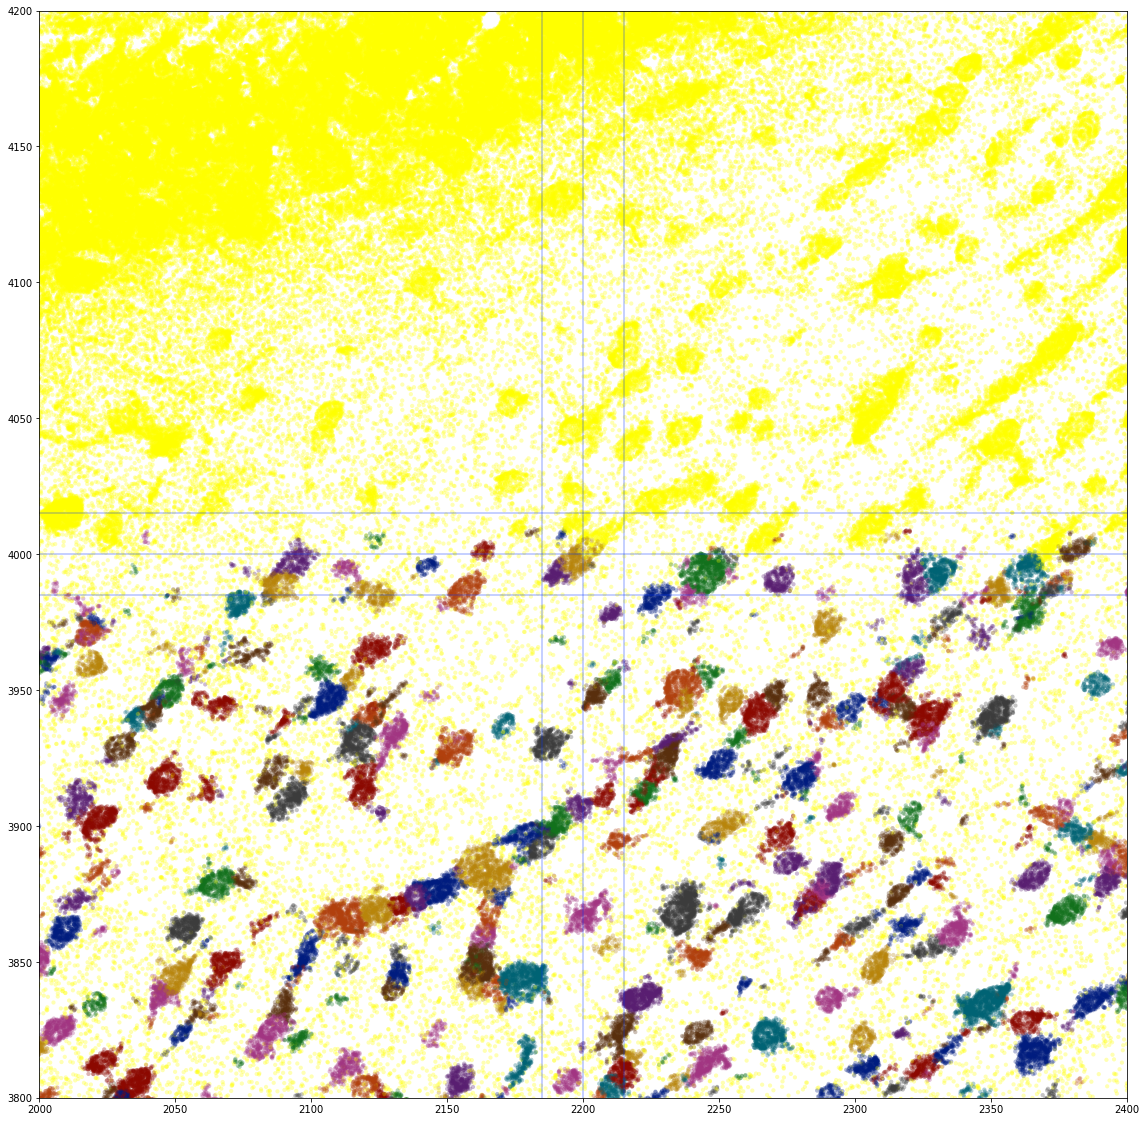

In [139]:
fig, ax = plt.subplots(figsize=(20, 20))
cell_scatter_plot(full_table, ax=ax, size=5, alpha=0.3)

c = (0, 0.2, 1.0, 0.3)
ax.axhline(3985, color=c)
ax.axhline(4000, color=c)
ax.axhline(4015, color=c)
ax.axvline(2185, color=c)
ax.axvline(2200, color=c)
ax.axvline(2215, color=c)

ax.set_xlim(2000, 2400)
ax.set_ylim(3800, 4200)


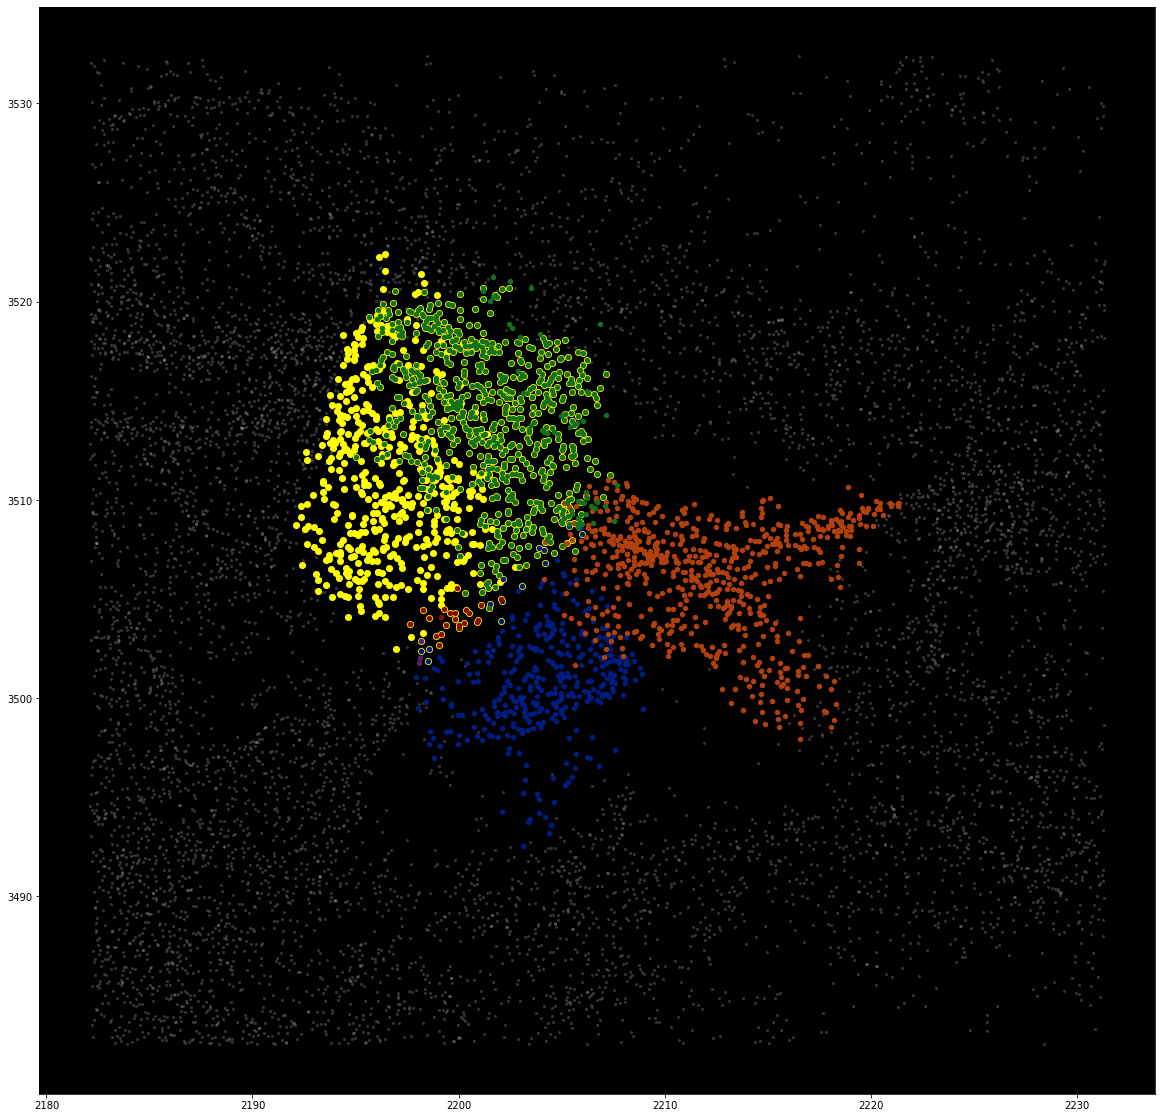

In [158]:
# plot conflicts

fig, ax = plt.subplots(figsize=(20, 20))
ax.set_facecolor('black')

# get region to plot
rec = overlapped_cells[0]
inds = set(rec['original_cell_inds'])
for cid, inds2 in rec['new_cell_inds'].items():
    inds = inds | inds2

spots = full_table[list(inds)]
xlim, ylim = spots.bounds()
conflict_rgn = full_table.get_subregion((xlim[0] - 10, xlim[1] + 10), (ylim[0] - 10, ylim[1] + 10))

orig_inds = conflict_rgn.map_indices_from_parent(rec['original_cell_inds'])
new_inds = {cid:conflict_rgn.cell_indices(cid) for cid in rec['new_cell_inds']}
conflict_rgn.cell_ids[:] = 0
conflict_rgn.cell_ids[orig_inds] -= 1
    
for cid, inds in new_inds.items():
    if cid == 0:
        continue
    conflict_rgn.cell_ids[inds] -= 2

# all spots first in grey
ax.scatter(conflict_rgn.data['x'], conflict_rgn.data['y'], color=(1, 1, 1, 0.2), linewidth=0, s=10)

# original cell in large yellow
cell_rgn = conflict_rgn[orig_inds]
ax.scatter(cell_rgn.data['x'], cell_rgn.data['y'], color=(1, 1, 0, 1), linewidth=0, s=50)

# overlapping cell(s) in smaller points, distributed colors 
# (will have yellow outline where overlapping)
colors = seaborn.color_palette('dark', len(rec['new_cell_ids']))
for i, inds in enumerate(new_inds.values()):
    cell_rgn = conflict_rgn[inds]
    ax.scatter(cell_rgn.data['x'], cell_rgn.data['y'], color=colors[i], linewidth=0, s=30)

    
#cell_scatter_plot(conflict_rgn, ax=ax, alpha=1.0)


In [122]:
rec['new_cell_ids']

array([16183, 16192, 16194, 19612, 22658])

In [126]:
set(rec['new_cell_inds'][16183]) & set(rec['original_cell_inds'])

{548034,
 548979,
 551878,
 563358,
 564940,
 564956,
 564980,
 564984,
 573083,
 574982,
 576873,
 581203,
 581413,
 582730}

In [113]:
len(rec['original_cell_inds'])

1152

In [116]:
conflict_rgn.cell_ids.min()

-2

In [30]:
import vispy.plot as vp

def scatter(tile):
    palette = cell_palette(tile.cell_ids)
    pos = np.stack([tile.data['x'], tile.data['y']], axis=1)
    color = np.array([list(palette[cid]) for cid in tile.cell_ids])
    c = vp.SceneCanvas(show=True)
    v = c.central_widget.add_view()
    sp = vp.Markers(pos=pos, face_color=color, edge_color=None, parent=v.scene)
    v.camera = 'panzoom'
    sp.set_gl_state(depth_test=False)
#     sp.set_gl_state('additive')
    return c, v, sp